### some statistics of the gbyk experiment

click [here](https://www.notion.so/in-progress-some-statistics-of-the-gbyk-experiment-17ca2d01e2ff80b28fa1e28899d36bd3?pvs=25) to access the corresponding notion page.

In [1]:
import os

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

In [2]:
from pathlib import Path

os.chdir(Path().resolve().parent)

In [3]:
sns.set_context("poster", font_scale=2.0)
sns.set_style("white")
sns.set_theme(style="ticks")

### histogram of trial duration

In [4]:
sessions = ["bex_20230623", "ken_20230614", "ken_20230618"]
trial_start = {session: [] for session in sessions}
trial_end = {session: [] for session in sessions}
choice = {session: [] for session in sessions}
reward = {session: [] for session in sessions}
trial_type = {session: [] for session in sessions}
com_dict = {session: [] for session in sessions}

for session in sessions:
    TRIALS_DIR = os.path.join(session, "trials")

    for trial in sorted(f for f in os.listdir(TRIALS_DIR)):
        with open(os.path.join(TRIALS_DIR, trial), "rb") as f:
            meta = yaml.safe_load(f)
        trial_type[session].append(meta["type"])
        choice[session].append(meta["choice"])
        reward[session].append(meta["reward"])
        start = meta["first_frame_idx"]
        end = start + meta["num_frames"]
        duration = end - start
        remainder = duration % 50
        idxs_adjustment = remainder != 0
        adjustment = np.where(idxs_adjustment, remainder, 0)
        start_adjustment = adjustment // 2
        end_adjustment = adjustment - start_adjustment
        trial_start[session].append(int(start + start_adjustment))
        trial_end[session].append(int(end - end_adjustment))
    
    POSES_DIR = os.path.join(session, "poses")
    with open(os.path.join(POSES_DIR, "meta", "com.npy"), "rb") as f:
        com = np.load(f)
        com_dict[session] = [
            com[b // 10 : e // 10, :].reshape((e - b) // 50, 5, 3).mean(axis=1)
            for b, e in zip(trial_start[session], trial_end[session])
        ]

In [5]:
df = pd.DataFrame(
    {
        "session": sessions,
        "trial_start": [trial_start[s] for s in sessions],
        "trial_end": [trial_end[s] for s in sessions],
        "choice": [choice[s] for s in sessions],
    }
)

df = df.explode(["trial_start", "trial_end", "choice"])
df["duration"] = (df["trial_end"] - df["trial_start"]) / 1000

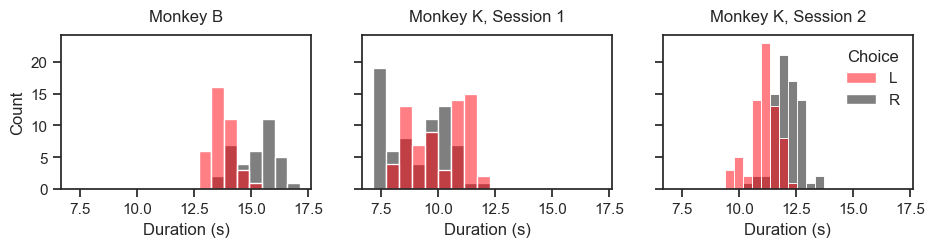

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(11, 2), sharex=True, sharey=True)
palette = sns.color_palette([sns.xkcd_rgb["bright red"], sns.xkcd_rgb["black"]])

for i, session in enumerate(sessions):
    session_df = df[df["session"] == session]
    if i == 2:
        g = sns.histplot(
            session_df,
            x="duration",
            hue="choice",
            ax=axs[i],
            palette=palette,
            legend=True,
        )
    else:
        g = sns.histplot(
            session_df,
            x="duration",
            hue="choice",
            ax=axs[i],
            palette=palette,
            legend=False,
        )
    axs[i].set_title(f"Session {session}", pad=7)
    axs[i].set_xlabel("Duration (s)")

axs[0].set_title(f"Monkey B", pad=10)
axs[1].set_title(f"Monkey K, Session 1", pad=10)
axs[2].set_title(f"Monkey K, Session 2", pad=10)

g.legend_.set_title("Choice")
g.legend_.set_frame_on(False)
plt.savefig(f"plots/trials_stats/histogram_duration.svg", format="svg", bbox_inches="tight")
plt.show()

### trials stats

In [7]:
print("bex_20230623:", Counter(trial_type["bex_20230623"]))
print("ken_20230614:", Counter(trial_type["ken_20230614"]))
print("ken_20230618:", Counter(trial_type["ken_20230618"]))

bex_20230623: Counter({'precue': 73})
ken_20230614: Counter({'precue': 71, 'gbyk': 66})
ken_20230618: Counter({'precue': 144})


In [8]:
for session in sessions:
    for c, r, t in zip(choice[session], reward[session], trial_type[session]):
        if c != r:
            print(f"{session}, type: {t}, choice: {c}, reward: {r}")

bex_20230623, type: precue, choice: L, reward: R
bex_20230623, type: precue, choice: R, reward: L
bex_20230623, type: precue, choice: L, reward: R
bex_20230623, type: precue, choice: R, reward: L
ken_20230614, type: precue, choice: L, reward: R
ken_20230614, type: precue, choice: L, reward: R
ken_20230614, type: precue, choice: R, reward: L
ken_20230618, type: precue, choice: L, reward: R
ken_20230618, type: precue, choice: L, reward: R
ken_20230618, type: precue, choice: R, reward: L
ken_20230618, type: precue, choice: R, reward: L
ken_20230618, type: precue, choice: R, reward: L
ken_20230618, type: precue, choice: R, reward: L
ken_20230618, type: precue, choice: R, reward: L
ken_20230618, type: precue, choice: R, reward: L
ken_20230618, type: precue, choice: L, reward: R


### traces of the center of mass across trials

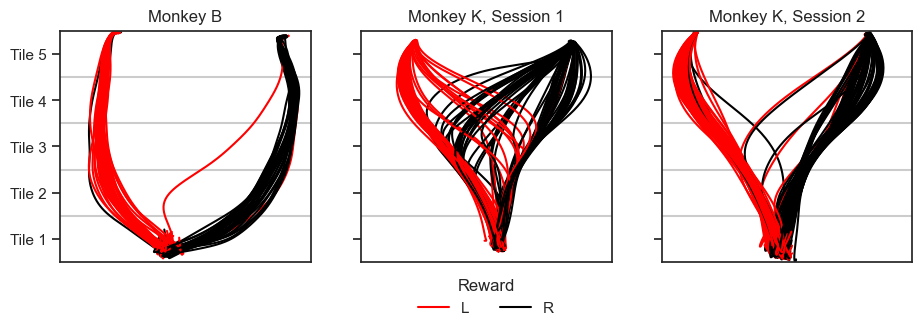

In [9]:
fig, axs = plt.subplots(1, len(sessions), figsize=(11, 3), sharex=True, sharey=True)

for i, session in enumerate(sessions):
    axs[i].axhline(y=0.2, color="black", linestyle="-", alpha=0.2)
    axs[i].axhline(y=0.4, color="black", linestyle="-", alpha=0.2)
    axs[i].axhline(y=0.6, color="black", linestyle="-", alpha=0.2)
    axs[i].axhline(y=0.8, color="black", linestyle="-", alpha=0.2)
    for c, t in zip(reward[session], com_dict[session]):
        if c == "L":
            axs[i].plot(t[:, 0], t[:, 1], color="red")
        else:
            axs[i].plot(t[:, 0], t[:, 1], color="black")

plt.xticks([])
yticks_positions = [0.1, 0.3, 0.5, 0.7, 0.9]
yticks_labels = ["Tile 1", "Tile 2", "Tile 3", "Tile 4", "Tile 5"]
axs[0].set_yticks(yticks_positions)
axs[0].set_yticklabels(yticks_labels)
axs[0].set_ylim(0, 1)
axs[0].set_title(f"Monkey B", pad=7)
axs[1].set_title(f"Monkey K, Session 1", pad=7)
axs[2].set_title(f"Monkey K, Session 2", pad=7)
axs[1].plot([], [], color="red", label="L")
axs[1].plot([], [], color="black", label="R")
axs[1].legend(title="Reward", frameon=False, bbox_to_anchor=(0.5, -0.15), ncols=2, loc="center")

plt.savefig(f"plots/trials_stats/traces_com.svg", format="svg", bbox_inches="tight")
plt.show()